In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import os
import xmltodict
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class VOCDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = self.load_labels()
        self.images = self.load_all_images()

    def load_labels(self):
        labels = []
        with open(os.path.join(self.data_dir, 'voc.names'), 'r') as f:
            labels = f.read().strip().split('\n')
        return labels

    def load_all_images(self):
        image_list = []
        image_dir = os.path.join(self.data_dir, 'JPEGImages')
        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg'):
                image_list.append(os.path.splitext(filename)[0])  # Añadir nombre de archivo sin extensión
        return image_list

    def parse_voc_annotation(self, annotation_file):
        with open(annotation_file, 'r') as f:
            xml_data = xmltodict.parse(f.read())
        objects = xml_data['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]
        annotations = []
        for obj in objects:
            label = obj['name']
            bbox = obj['bndbox']
            xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
            annotations.append((xmin, ymin, xmax, ymax, self.labels.index(label)))
        return annotations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, 'JPEGImages', self.images[idx] + '.jpg')
        annotation_path = os.path.join(self.data_dir, 'Annotations', self.images[idx] + '.xml')
        image = Image.open(image_path).convert('RGB')
        annotations = self.parse_voc_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, annotations

In [21]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((800, 600)),
    transforms.ToTensor()
])

data_dir = './Camerav4ivoc/train/'
dataset = VOCDataset(data_dir, transform=data_transforms)

# Para acceder a un ejemplo del conjunto de datos
image, annotations = dataset[0]
print("Image shape:", image.shape)
print("Annotations:", annotations)

classes = ["camera", "router", "car"]
train = dataset

Image shape: torch.Size([3, 800, 600])
Annotations: [(105, 192, 459, 571, 0)]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

def get_sample(ix):
    img, labels = train[ix]
    img_np = np.array(img)
    
    # Suponiendo que las coordenadas del cuadro delimitador y la etiqueta están en una tupla en labels
    bbs = np.array([[int(xmin), int(ymin), int(xmax), int(ymax)] for xmin, ymin, xmax, ymax, _ in labels])
    labels = np.array([int(etiqueta) for _, _, _, _, etiqueta in labels])
    
    anns = (labels, bbs)
    return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, img_shape=(800, 600, 3)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img.reshape(img_shape))
    
    labels, bbs = anns
    for lab, bb in zip(labels, bbs):
        if bg == -1 or lab != bg:
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            text = ax.text(x, y - 10, classes[lab], color='red', fontsize=10, ha='left')
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='white')]) #type: ignore
            ax.add_patch(rect)

In [23]:
img_np, anns = get_sample(0)
img_np.shape, anns

((3, 800, 600), (array([0]), array([[105, 192, 459, 571]])))

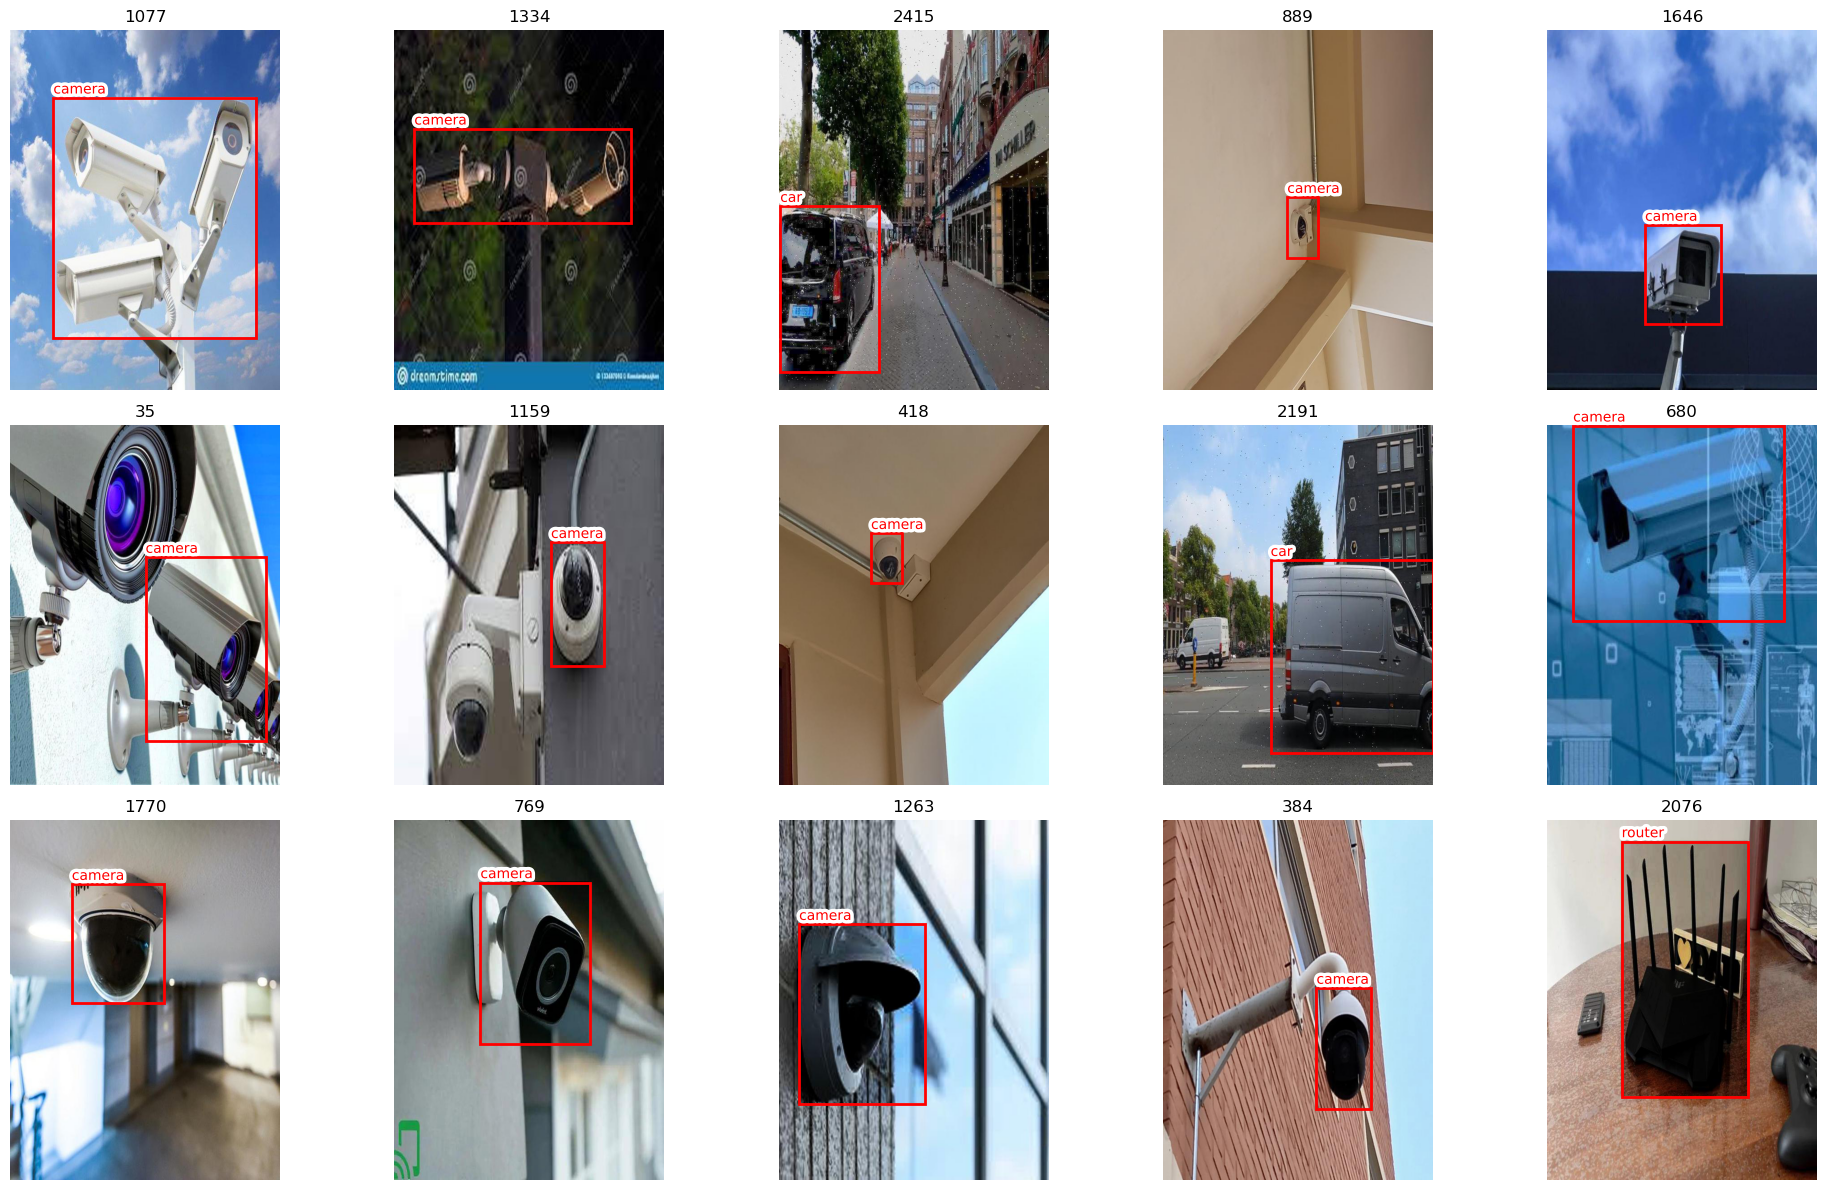

In [29]:
import random

r, c = 3, 5
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
from torchvision.models.detection import retinanet_resnet50_fpn

model = retinanet_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to C:\Users\israe/.cache\torch\hub\checkpoints\retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:21<00:00, 6.29MB/s] 


In [12]:
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
